In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib.pyplot import figure

import matplotlib.pyplot as plt

import json
import re
import time
from copy import deepcopy



In [2]:
!pip install kafka-python

In [3]:
# Import the python Consumer Client for Kafka
from kafka import KafkaConsumer

# Problem 1

## Static

## Reading and preprocessing 

Read the data

In [4]:
cic = pd.read_csv('/content/drive/MyDrive/AIforCS/Kafka/cicids_static_data.csv')

In [5]:
cic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25191 entries, 0 to 25190
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0    Destination Port             25191 non-null  int64  
 1    Flow Duration                25191 non-null  int64  
 2    Total Fwd Packets            25191 non-null  int64  
 3    Total Backward Packets       25191 non-null  int64  
 4   Total Length of Fwd Packets   25191 non-null  int64  
 5    Total Length of Bwd Packets  25191 non-null  int64  
 6    Fwd Packet Length Max        25191 non-null  int64  
 7    Fwd Packet Length Min        25191 non-null  int64  
 8    Fwd Packet Length Mean       25191 non-null  float64
 9    Fwd Packet Length Std        25191 non-null  float64
 10  Bwd Packet Length Max         25191 non-null  int64  
 11   Bwd Packet Length Min        25191 non-null  int64  
 12   Bwd Packet Length Mean       25191 non-null  float64
 13   

In [6]:
cic = cic.replace([-np.inf,np.inf], np.nan).dropna()

Ecoding the Label

In [7]:
cic['Label'] = cic['Label'].map({'ATTACK':1, 'BENIGN':0})

In [8]:
y = cic['Label']
X = cic.drop('Label',axis=1)

In [9]:
X.head(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,53,159,2,2,68,266,34,34,34.000000,0.000000,133,133,133.000000,0.000000,2.100629e+06,25157.232700,5.300000e+01,9.006664e+01,157,1,1,1.000000e+00,0.000000e+00,1,1,1,1.000000e+00,0.000000e+00,1,1,0,0,0,0,40,40,12578.616350,12578.616350,34,133,73.600000,54.224533,2.940300e+03,0,0,0,0,0,0,0,0,1,92.000000,34.000000,133.000000,40,0,0,0,0,0,0,2,68,2,266,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,53,51673,2,2,90,166,45,45,45.000000,0.000000,83,83,83.000000,0.000000,4.954231e+03,77.409866,1.722433e+04,2.982736e+04,51666,3,4,4.000000e+00,0.000000e+00,4,4,3,3.000000e+00,0.000000e+00,3,3,0,0,0,0,64,64,38.704933,38.704933,45,83,60.200000,20.813457,4.332000e+02,0,0,0,0,0,0,0,0,1,75.250000,45.000000,83.000000,64,0,0,0,0,0,0,2,90,2,166,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0
2,7496,43,1,1,0,6,0,0,0.000000,0.000000,6,6,6.000000,0.000000,1.395349e+05,46511.627910,4.300000e+01,0.000000e+00,43,43,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,20,23255.813950,23255.813950,0,6,2.000000,3.464102,1.200000e+01,0,0,0,1,0,0,0,0,1,3.000000,0.000000,6.000000,40,0,0,0,0,0,0,1,0,1,6,29200,0,0,40,0.0,0.0,0,0,0.0,0.0,0,0
3,46564,61,1,1,6,6,6,6,6.000000,0.000000,6,6,6.000000,0.000000,1.967213e+05,32786.885250,6.100000e+01,0.000000e+00,61,61,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,20,20,16393.442620,16393.442620,6,6,6.000000,0.000000,0.000000e+00,0,0,0,0,1,1,0,0,1,9.000000,6.000000,6.000000,20,0,0,0,0,0,0,1,6,1,6,440,307,0,20,0.0,0.0,0,0,0.0,0.0,0,0
4,80,69,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,28985.507250,6.900000e+01,0.000000e+00,69,69,69,6.900000e+01,0.000000e+00,69,69,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,0,28985.507250,0.000000,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,40,0,0,0,0,0,0,2,0,0,0,251,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0
5,80,98403702,7,5,377,11595,377,0,53.857143,142.492606,7240,0,2319.000000,3331.638186,1.216621e+02,0.121947,8.945791e+06,2.970000e+07,98400000,1,98400000,1.640000e+07,4.020000e+07,98400000,1,48396,1.209900e+04,1.746332e+04,37136,85,0,0,0,0,232,168,0.071136,0.050811,0,7240,920.923077,2243.600063,5.033741e+06,0,0,0,0,1,0,0,0,0,997.666667,53.857143,2319.000000,232,0,0,0,0,0,0,7,377,5,11595,251,235,1,32,986.0,0.0,986,986,98400000.0,0.0,98400000,98400000
6,53,30843,1,1,54,70,54,54,54.000000,0.000000,70,70,70.000000,0.000000,4.020361e+03,64.844535,3.084300e+04,0.000000e+00,30843,30843,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,40,32.422268,32.422268,54,70,59.333333,9.237604,8.533333e+01,0,0,0,0,0,0,0,0,1,89.000000,54.000000,70.000000,40,0,0,0,0,0,0,1,54,1,70,-1,-1,0,40,0.0,0.0,0,0,0.0,0.0,0,0
7,80,5421062,4,4,

Sclaing the data using 0 mean normlization

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X.to_numpy())

Splitting the data to train and test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Training and Testing

RandomForest

In [12]:
# Create the random grid
param_grid = {
    'max_depth': [10, 20, 30],
    'max_features': ['auto'],
    'min_samples_leaf': [2,3, 4],
    'min_samples_split': [2,3,4],
    'n_estimators': [5, 10, 20],
    'ccp_alpha':[0.01,0.1,0]
}
# Create a based model
rf = RandomForestClassifier(random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': [0.01, 0.1, 0], 'max_depth': [10, 20, 30],
                         'max_features': ['auto'],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [5, 10, 20]},
             verbose=2)

In [13]:
grid_search.best_params_

{'ccp_alpha': 0,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 20}

In [14]:
static_rf = RandomForestClassifier(random_state=0,
 max_depth= 20,
 max_features='auto',
 min_samples_leaf= 2,
 min_samples_split= 2,
 n_estimators= 20)
static_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=20,
                       random_state=0)

In [15]:
y_pred = static_rf.predict(X_test)
score = precision_recall_fscore_support(y_test, y_pred,average='weighted')
print('Precision: ',score[0],'\nRecall: ',score[1],'\nF1 Score: ',score[2])

Precision:  0.9980116059721886 
Recall:  0.9980142970611596 
F1 Score:  0.9980125099422075


GradiantBoosting

In [16]:
# Create the random grid
param_grid = {
    'n_estimators': [5, 10, 20],
    'learning_rate':[0.01,0.1,1]
}
# Create a based model
ab = AdaBoostClassifier(random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ab, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [5, 10, 20]},
             verbose=2)

In [17]:
grid_search.best_params_

{'learning_rate': 1, 'n_estimators': 20}

In [18]:
static_ab = AdaBoostClassifier(n_estimators=20,learning_rate= 1, random_state=0).fit(X_train, y_train)

In [19]:
y_pred = static_ab.predict(X_test)
score = precision_recall_fscore_support(y_test, y_pred, average='micro')
print('Precision: ',score[0],'\nRecall: ',score[1],'\nF1 Score: ',score[2])

Precision:  0.994042891183479 
Recall:  0.994042891183479 
F1 Score:  0.994042891183479


Choosing random forest and take a copy from it.

In [20]:
dynamic_rf = deepcopy(static_rf)

## Dynamic

In [21]:
# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
consumer = KafkaConsumer(
    'task1',   # change this to "task2" for the IOT Botnet Detection  ---- important ----
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [22]:
def get_data(consumer):
  # Data Stream flowing in.
  i = 0
  X_t = []
  y_t = []
  for message in consumer:
      data_packet = message.value
      try:
        # transform the packet from json to list. 
        input= str(data_packet, 'utf-8')
        input=re.sub('\'','\"',input)
        res = json.loads(input)
        X_d = np.array(list(res.values())[:-1]).reshape(1,-1)
        y_d = list(res.values())[-1]
        
        X_t.append(X_d[0])
        y_t.append(y_d)
        i += 1   
      except:
        pass
      if i == 1000:
          break
  return np.array(X_t),np.array(y_t)

In [23]:
import math

In [24]:
# list of static model scores
static_scores = []
# list of dynamic model scores
dynamic_scores = []

for i in range(1,100):
  # get data from kafka server.
  X_d,y_d = get_data(consumer)

  # preprocessing the gotten data.
  X_d = scaler.transform(X_d) 
  y_d = list(map(lambda x: 1 if x == 'ATTACK' else 0, y_d))
  print('Iteration No.',i)
  try:
    # test data from kafka using static model.
    y_pred = static_rf.predict(X_d)
    score = precision_recall_fscore_support(y_d, y_pred,average='micro')
    static_scores.append(score)
    print('Static Model - New 1000 - Precision: ',score[0],'  Recall: ',score[1],'  F1 Score: ',score[2])
    # test data from kafka using dynamic model.
    y_pred = dynamic_rf.predict(X_d)
    score = precision_recall_fscore_support(y_d, y_pred,average='micro')
    dynamic_scores.append(score)
    print('Dynamic Model - New 1000 - Precision: ',score[0],'  Recall: ',score[1],'  F1 Score: ',score[2])

    # add the new data to the orignal data and remove the oldes with the same length.
    X_new = X
    y_new = y
    X_new = X_new[:len(X_new)-1000]
    y_new = y_new[:len(y_new)-1000]
    X_new = np.concatenate((X_new, X_d), axis=0)
    y_new = np.concatenate((y_new, y_d), axis=0)

    # fitting the dynamic model using prepared data.
    dynamic_rf = dynamic_rf.fit(X_new,y_new)
  except Exception as e:
    print(str(e))


Iteration No. 1
Static Model - New 1000 - Precision:  0.999   Recall:  0.999   F1 Score:  0.999
Dynamic Model - New 1000 - Precision:  0.999   Recall:  0.999   F1 Score:  0.999
Iteration No. 2
Static Model - New 1000 - Precision:  0.997   Recall:  0.997   F1 Score:  0.997
Dynamic Model - New 1000 - Precision:  0.995   Recall:  0.995   F1 Score:  0.995
Iteration No. 3
Static Model - New 1000 - Precision:  0.996   Recall:  0.996   F1 Score:  0.996
Dynamic Model - New 1000 - Precision:  0.996   Recall:  0.996   F1 Score:  0.996
Iteration No. 4
Static Model - New 1000 - Precision:  0.997   Recall:  0.997   F1 Score:  0.997
Dynamic Model - New 1000 - Precision:  0.995   Recall:  0.995   F1 Score:  0.995
Iteration No. 5
Static Model - New 1000 - Precision:  0.996   Recall:  0.996   F1 Score:  0.996
Dynamic Model - New 1000 - Precision:  0.997   Recall:  0.997   F1 Score:  0.997
Iteration No. 6
Static Model - New 1000 - Precision:  0.995   Recall:  0.995   F1 Score:  0.995
Dynamic Model - New

## Plotting the results

In [25]:
np.array(static_scores)[:,2]

array([0.999, 0.997, 0.996, 0.997, 0.996, 0.995, 0.998, 0.996, 0.997,
       0.999, 0.998, 0.999, 0.995, 0.997, 0.997, 0.996, 0.997, 0.995,
       0.997, 0.995, 0.997, 0.999, 0.99, 0.998, 0.994, 0.998, 0.995,
       0.993, 0.993, 0.999, 0.994, 0.999, 0.996, 0.996, 0.998, 0.997,
       0.997, 0.998, 0.995, 0.996, 0.998, 0.996, 0.994, 0.997, 0.996,
       0.999, 1.0, 0.997, 0.999, 0.994, 0.996, 0.998, 0.999, 0.999, 0.992,
       0.994, 0.997, 0.995, 0.999, 0.994, 1.0, 0.997, 0.992, 0.998, 0.999,
       0.998, 0.997, 0.998, 0.993, 0.997, 0.997, 0.996, 0.993, 0.996,
       0.998, 0.995, 0.998, 0.997, 0.996, 1.0, 0.998, 0.998, 0.995, 0.997,
       0.998, 0.999, 0.998, 0.998, 0.996, 0.998, 0.997, 0.997, 1.0, 0.996,
       0.996, 0.996, 0.995, 0.995, 0.992], dtype=object)

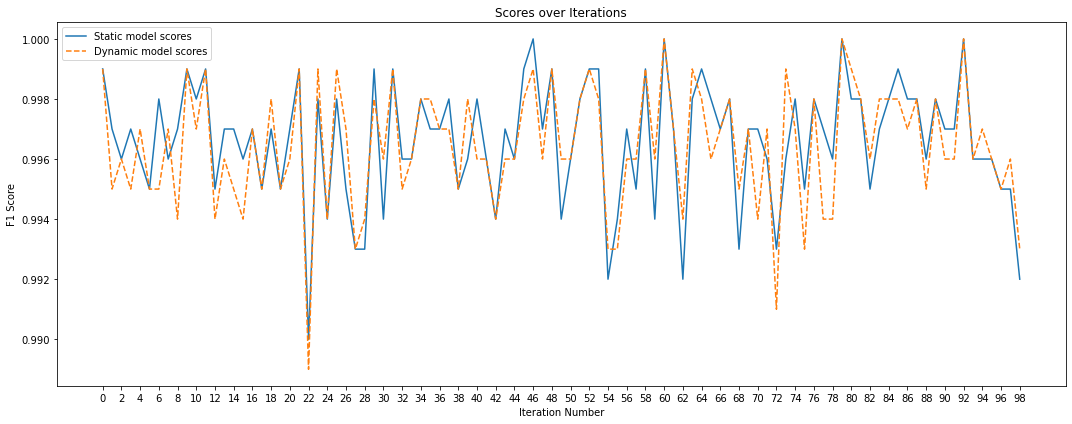

In [26]:

figure(figsize=(15, 6))
x_axis = list(range(0,99))

plt.plot(x_axis, np.array(static_scores)[:,2], label='Static model scores')
plt.plot(x_axis, np.array(dynamic_scores)[:,2],linestyle='dashed' , label='Dynamic model scores')

plt.title("Scores over Iterations")
plt.xlabel("Iteration Number")
plt.ylabel("F1 Score")
plt.xticks(list(range(0,99,2)))
plt.legend()
plt.tight_layout()
plt.show()

The average of all iterations precision, recall and F1 scores.

In [27]:
static_avg_precision = np.array(static_scores)[:,0].mean()
static_avg_recall = np.array(static_scores)[:,1].mean()
stativ_avg_f1_score = np.array(static_scores)[:,2].mean()

dynamic_avg_precision = np.array(dynamic_scores)[:,0].mean()
dynamic_avg_recall = np.array(dynamic_scores)[:,1].mean()
dynamic_avg_f1_score = np.array(dynamic_scores)[:,2].mean()

print('Static Model average precision: ',static_avg_precision,' average recall: ',static_avg_recall,' average f1_score: ',stativ_avg_f1_score)
print('Dynamic Model average precision: ',dynamic_avg_precision,' average recall: ',dynamic_avg_recall,' average f1_score: ',stativ_avg_f1_score)

Static Model average precision:  0.9966161616161618  average recall:  0.9966161616161618  average f1_score:  0.9966161616161618
Dynamic Model average precision:  0.9964343434343437  average recall:  0.9964343434343437  average f1_score:  0.9966161616161618


# Problem 2

## Reading and Preprocessing the data

Read the data

In [28]:
iot = pd.read_csv('/content/drive/MyDrive/AIforCS/Kafka/iot_static_data.csv')

In [29]:
iot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25609 entries, 0 to 25608
Columns: 117 entries, MI_dir_L5_weight to Class
dtypes: float64(115), object(2)
memory usage: 22.9+ MB


In [30]:
obj_cols = iot.select_dtypes(include=['object']).columns

In [31]:
obj_cols

Index(['Source', 'Class'], dtype='object')

In [32]:
iot.columns.get_loc("Source")

115

In [33]:
iot['Source'].value_counts()

Philips B120N10 Baby Monitor                7575
Provision PT 838 Security Camera            4557
Provision PT 737E Security Camera           2820
Danmini Doorbell                            2602
SimpleHome XCS7 1002 WHT Security Camera    2338
Samsung SNH 1011 N Webcam                   2187
Ennio Doorbell                              1701
Ecobee Thermostat                            954
SimpleHome XCS7 1003 WHT Security Camera     875
Name: Source, dtype: int64

In [34]:
iot.drop('Source',axis=1,inplace=True)

In [35]:
iot['Class'].value_counts()

BENIGN                   22287
mirai_udp_attack          1774
gafgyt_udp_attack          446
gafgyt_junk_attack         377
gafgyt_tcp_attack          213
gafgyt_scan_attack         200
mirai_syn_attack           101
mirai_ack_attack            96
mirai_scan_attack           86
gafgyt_combo_attack         18
mirai_udpplain_attack       11
Name: Class, dtype: int64

In [36]:
iot = iot.replace([-np.inf,np.inf], np.nan).dropna()

Ecoding the Label

In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
iot['Class'] = le.fit_transform(iot['Class'])

In [38]:
y_iot = iot['Class']
X_iot = iot.drop('Class',axis=1)

Sclaing the data using 0 mean normlization

In [39]:
scaler = StandardScaler()
X_iot = scaler.fit_transform(X_iot.to_numpy())

Splitting the data to train and test

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_iot, y_iot, test_size=0.20, random_state=42,stratify=y_iot)

## Training and Testing

Random forest

In [41]:
# Create the random grid
param_grid = {
    'max_depth': [10, 20, 30],
    'max_features': ['auto'],
    'min_samples_leaf': [2,3, 4],
    'min_samples_split': [2,3,4],
    'n_estimators': [5, 10, 20],
    'ccp_alpha':[0.01,0.1,0]
}
# Create a based model
rf = RandomForestClassifier(random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': [0.01, 0.1, 0], 'max_depth': [10, 20, 30],
                         'max_features': ['auto'],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [5, 10, 20]},
             verbose=2)

In [42]:
grid_search.best_params_

{'ccp_alpha': 0,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 10}

In [43]:
static_rf = RandomForestClassifier(random_state=0,
                                   ccp_alpha= 0,
                                   max_depth= 10,
                                   max_features= 'auto',
                                   min_samples_leaf= 2,
                                   min_samples_split= 2,
                                   n_estimators= 10)
static_rf.fit(X_train, y_train)
static_rf.score(X_test, y_test)

0.9992190550566185

In [44]:
y_pred = static_rf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred , average=None , labels=list(range(0,11)))[2]

array([1.        , 0.57142857, 0.97333333, 0.98765432, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [45]:
score = precision_recall_fscore_support(y_test, y_pred,average='weighted')
print('Precision: ',score[0],'\nRecall: ',score[1],'\nF1 Score: ',score[2])

Precision:  0.9991587381707476 
Recall:  0.9992190550566185 
F1 Score:  0.9991784238823156


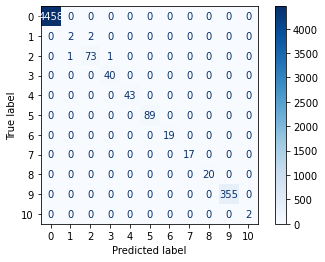

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_estimator(static_rf, X_test, y_test,cmap=plt.cm.Blues)

In [47]:
le.inverse_transform(list(range(0,11)))

array(['BENIGN', 'gafgyt_combo_attack', 'gafgyt_junk_attack',
       'gafgyt_scan_attack', 'gafgyt_tcp_attack', 'gafgyt_udp_attack',
       'mirai_ack_attack', 'mirai_scan_attack', 'mirai_syn_attack',
       'mirai_udp_attack', 'mirai_udpplain_attack'], dtype=object)

GradientBoosting

In [48]:
# Create the random grid
param_grid = {
    'n_estimators': [5, 10, 20],
    'learning_rate':[0.01,0.1,1]
}
# Create a based model
ab = AdaBoostClassifier(random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ab, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [5, 10, 20]},
             verbose=2)

In [49]:
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 20}

In [50]:
static_ab = AdaBoostClassifier(n_estimators=20, random_state=0,learning_rate= 0.1).fit(X_train, y_train)
static_ab.score(X_test, y_test)

0.9697383834439672

In [51]:
y_pred = static_ab.predict(X_test)
precision_recall_fscore_support(y_test, y_pred , average=None , labels=list(range(0,11)),zero_division=True)[2]

array([0.98541114, 0.        , 0.96774194, 1.        , 0.        ,
       0.        , 0.25      , 1.        , 0.97435897, 0.97796143,
       0.        ])

In [52]:
score = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print('Precision: ',score[0],'\nRecall: ',score[1],'\nF1 Score: ',score[2])

Precision:  0.9426393216293537 
Recall:  0.9697383834439672 
F1 Score:  0.9554777426610505


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


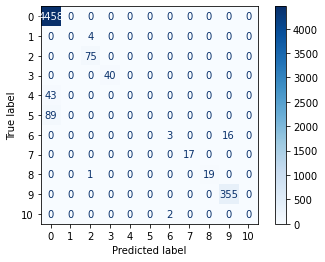

In [53]:
ConfusionMatrixDisplay.from_estimator(static_ab, X_test, y_test,cmap=plt.cm.Blues)

Choosing random forest

In [54]:
dynamic_rf = deepcopy(static_rf)

In [55]:
# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
consumer = KafkaConsumer(
    'task2',   # change this to "task2" for the IOT Botnet Detection  ---- important ----
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [56]:
# list of static model scores
static_scores = []
# list of dynamic model scores
dynamic_scores = []

for i in range(1,100):
  # get data from kafka server.
  X_d,y_d = get_data(consumer)

  # preprocessing the gotten data.
  X_d = np.delete(X_d, 115, axis=1)
  y_d = le.transform(y_d)
  iot = iot.replace([-np.inf,np.inf], np.nan).dropna()
  X_d = scaler.transform(X_d) 

  print('Iteration No.',i)
  try:
    # test data from kafka using static model.
    y_pred = static_rf.predict(X_d)
    score = precision_recall_fscore_support(y_d, y_pred,zero_division=True,average='macro')
    static_scores.append(score)
    print('Static Model - New 1000 - Precision: ',score[0],'  Recall: ',score[1],'  F1 Score: ',score[2])
    # test data from kafka using dynamic model.
    y_pred = dynamic_rf.predict(X_d)
    score = precision_recall_fscore_support(y_d, y_pred,zero_division=True,average='macro')
    dynamic_scores.append(score)
    print('Static Model - New 1000 - Precision: ',score[0],'  Recall: ',score[1],'  F1 Score: ',score[2])
    # add the new data to the orignal data and remove the oldes with the same length.
    X_new = X_iot
    y_new = y_iot

    X_new = X_new[:len(X_new)-1000]
    y_new = y_new[:len(y_new)-1000]

    X_new = np.concatenate((X_new, X_d), axis=0)
    y_new = np.concatenate((y_new, y_d), axis=0)

    # fitting the dynamic model using prepared data.
    dynamic_rf = dynamic_rf.fit(X_new,y_new)
  except Exception as e:
    print(str(e))

Iteration No. 1
Static Model - New 1000 - Precision:  0.9943181818181818   Recall:  0.9090909090909091   F1 Score:  0.9061583577712611
Static Model - New 1000 - Precision:  0.9943181818181818   Recall:  0.9090909090909091   F1 Score:  0.9061583577712611
Iteration No. 2
Static Model - New 1000 - Precision:  0.975   Recall:  0.95   F1 Score:  0.9523809523809523
Static Model - New 1000 - Precision:  0.975   Recall:  0.95   F1 Score:  0.9523809523809523
Iteration No. 3
Static Model - New 1000 - Precision:  1.0   Recall:  1.0   F1 Score:  1.0
Static Model - New 1000 - Precision:  1.0   Recall:  1.0   F1 Score:  1.0
Iteration No. 4
Static Model - New 1000 - Precision:  0.9915530303030303   Recall:  0.8916666666666666   F1 Score:  0.8916098161834375
Static Model - New 1000 - Precision:  0.9914396519107076   Recall:  0.8816666666666666   F1 Score:  0.8862898724082935
Iteration No. 5
Static Model - New 1000 - Precision:  0.9947368421052631   Recall:  0.9   F1 Score:  0.8972972972972972
Static M

## Plotting the results

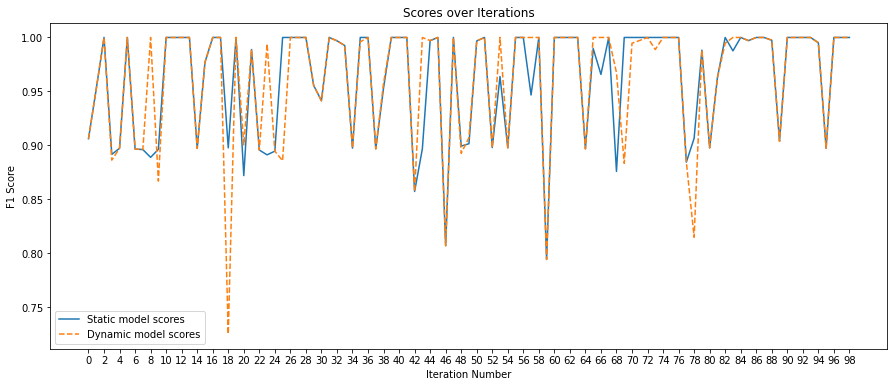

In [57]:
figure(figsize=(15, 6))
x_axis = list(range(0,99))

plt.plot(x_axis, np.array(static_scores)[:,2], label='Static model scores')
plt.plot(x_axis, np.array(dynamic_scores)[:,2],linestyle='dashed' , label='Dynamic model scores')

plt.title("Scores over Iterations")
plt.xlabel("Iteration Number")
plt.ylabel("F1 Score")
plt.xticks(list(range(0,99,2)))
plt.legend()
plt.show()

The average of all iterations precision, recall and F1 scores.



In [58]:
static_avg_precision = np.array(static_scores)[:,0].mean()
static_avg_recall = np.array(static_scores)[:,1].mean()
stativ_avg_f1_score = np.array(static_scores)[:,2].mean()

dynamic_avg_precision = np.array(dynamic_scores)[:,0].mean()
dynamic_avg_recall = np.array(dynamic_scores)[:,1].mean()
dynamic_avg_f1_score = np.array(dynamic_scores)[:,2].mean()

print('Static Model average precision: ',static_avg_precision,' average recall: ',static_avg_recall,' average f1_score: ',stativ_avg_f1_score)
print('Dynamic Model average precision: ',dynamic_avg_precision,' average recall: ',dynamic_avg_recall,' average f1_score: ',dynamic_avg_f1_score)

Static Model average precision:  0.9918517719467618  average recall:  0.964516481774628  average f1_score:  0.9613635495190552
Dynamic Model average precision:  0.993101983741898  average recall:  0.9641293036779405  average f1_score:  0.9616505702001719
